# Packages and Configurations

In [1]:
import numpy as np
from numba import njit
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib import pyplot as plt
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath, physics}")
plt.rc("font", family="serif", serif=["Computer Modern"])
plt.rc("axes", titlesize=20, labelsize=18) 
plt.rc("figure", titlesize=20)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

# Model

In [2]:
@njit
def brock_hommes_map(x, y, z, randtrade, m, d, r,
                     belief, chi, phi, beta, kappa):
    xnew = ((1 - z) / 2 * (1 + chi) * x + (1 + z) / 2 * (1 - phi) * x
                - belief * (m * (x - y) + d * x - randtrade)) / (1 + r)
    return (xnew, x, np.tanh(beta / 2 * (
        ((1 + r) * x - xnew) * (chi + phi) * y / belief - kappa)))

@njit
def brock_hommes_solution(t, x0, y0, z0, randtrade, m, d, r,
                          belief, chi, phi, beta, kappa):
    xs, ys, zs = np.empty(t + 1), np.empty(t + 1), np.empty(t + 1)
    xs[0], ys[0], zs[0] = x0, y0, z0
    for i in range(t):
        xs[i + 1], ys[i + 1], zs[i + 1] = brock_hommes_map(
            xs[i], ys[i], zs[i], randtrade[i], m, d, r, belief,
            chi, phi, beta, kappa)
    return xs, ys, zs

@njit
def brock_hommes_parameters(xs, ys, zs, m, d, r, phi, belief):
    volatility = np.abs(xs - ys)
    mispricing = np.abs(xs)
    intervention = -m * (xs - ys) - d * xs
    abs_intervention = np.abs(intervention)
    profit = (xs - (1 + r) * ys)[1:] * intervention[:-1]
    fundamentalist_weight = (1 + zs) / 2
    fundamentalist_abs_pos = (
        (1 + zs) / 2 * np.abs((1 - phi) * ys - (1 + r) * xs) / belief)
    return (volatility, mispricing, abs_intervention, profit,
            fundamentalist_weight, fundamentalist_abs_pos)

# Bifurcation

In [3]:
def bifurcate(liquid_var, all_params, param_idx, param_values, xvals,
              z0=-1.0, iterations=1000):
    param_values = np.reshape(param_values, (1, len(param_values))) 
    param_values = np.repeat(param_values, len(xvals), axis=0)

    xvals = np.reshape(xvals, (len(xvals), 1))
    xvals = np.repeat(xvals, np.size(param_values, 1), axis=1)

    all_params = all_params[:]
    all_params[param_idx] = param_values

    xs, ys, zs = xvals, xvals, z0 * np.ones_like(xvals)
    for _ in range(iterations):
        xs, ys, zs = brock_hommes_map(xs, ys, zs,
            np.random.normal(0, liquid_var**0.5, np.shape(xvals)), *all_params)
    return param_values, xs, ys

In [4]:
def bifurcate_trail(x0, y0, z0, liquid_var, all_params, param_idx,
                    param_values, time=100000, trail=400):
    xs = np.empty((len(param_values), trail))
    ys = np.empty_like(xs)
    for (i, param) in enumerate(param_values):
        all_params = all_params[:]
        all_params[param_idx] = param
        randtrade = np.random.normal(0, liquid_var**0.5, time)
        new_xs, new_ys, _ = brock_hommes_solution(
            time, x0, y0, z0, randtrade, *all_params)
        xs[i], ys[i] = new_xs[-trail:], new_ys[-trail:]

    param_values = np.reshape(param_values, (1, len(param_values))) 
    param_values = np.repeat(param_values, trail, axis=0)
    return param_values, xs, ys
        

# Plotting

In [5]:
def plot_relation(ax, x, y, xlabel="time step", ylabel="asset price",
                  ylim=(7.5, 12.5), color="mediumblue", **kwargs):
    ax.plot(x, y, c=color, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid()

def plot_bifurcation(ax, params, xs, ylabel="asset price",
                     ylim=(7.5, 12.5), alpha=0.1, **kwargs):
    ax.scatter(params.flat, xs.flat, 1, lw=0, alpha=alpha,
               marker="s", color="black", **kwargs)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

# Constants

In [6]:
r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
liquid_var = 0.0025

# No intervention
## Dynamics

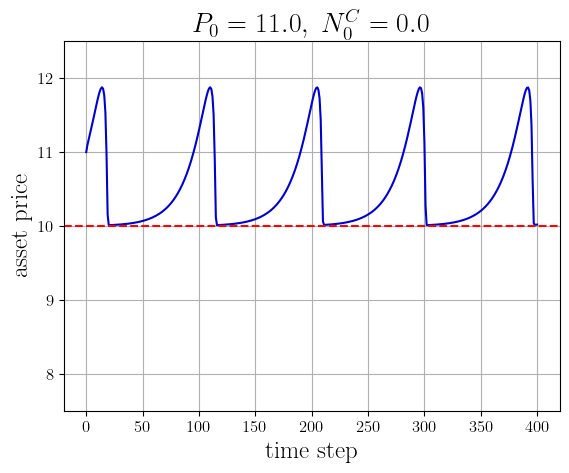

In [116]:
x0, y0, z0 = 1.0, 1.0, -1.0
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, np.zeros(400), 0, 0,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"$P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("no-intervention-1.pdf", bbox_inches="tight")
plt.show()

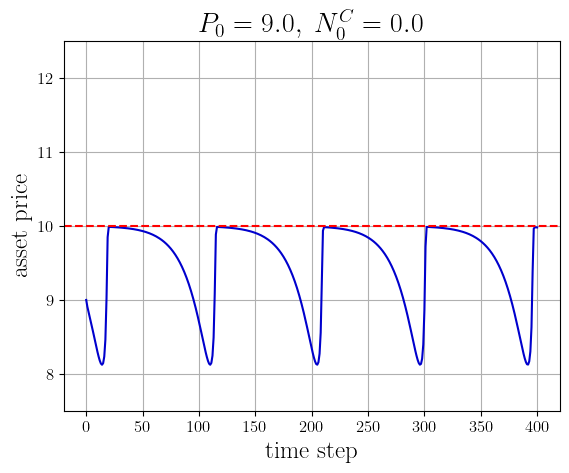

In [117]:
x0, y0, z0 = -1.0, -1.0, -1.0
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, np.zeros(400), 0, 0,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"$P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("no-intervention-2.pdf", bbox_inches="tight")
plt.show()

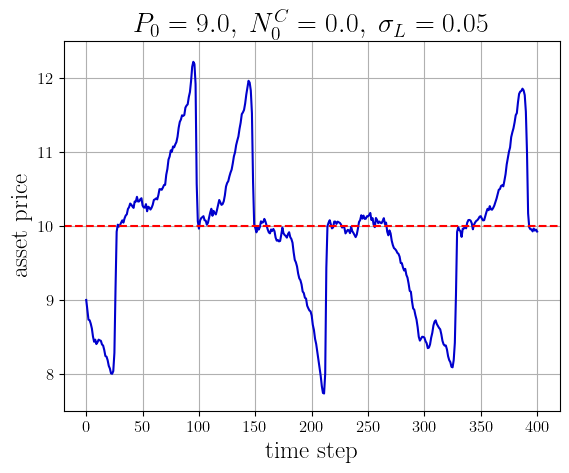

In [118]:
x0, y0, z0 = -1.0, -1.0, -1.0
randtrade = np.random.normal(0, liquid_var**0.5, 400)
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, randtrade, 0, 0,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"$P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$")

plt.savefig("no-intervention-stochastic.pdf", bbox_inches="tight")
plt.show()

## Bifurcation

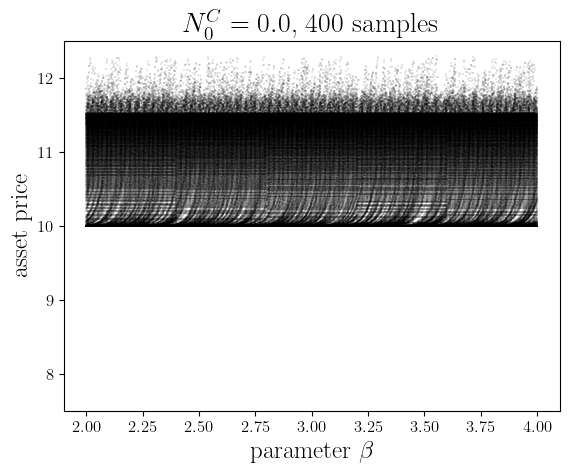

In [192]:
betas = np.linspace(2.0, 4.0, 1000)
xs = np.linspace(0.001, 2.5, 100)
iterations = 100000
betas, xs, ys = bifurcate(0, [0, 0, r, belief, chi, phi, beta, kappa],
                      -2, betas, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, betas, xs + 10)
ax.set_xlabel(r"parameter $\beta$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("no-intervention-bifurcation-1.png",
            bbox_inches="tight", dpi=300)
plt.show()

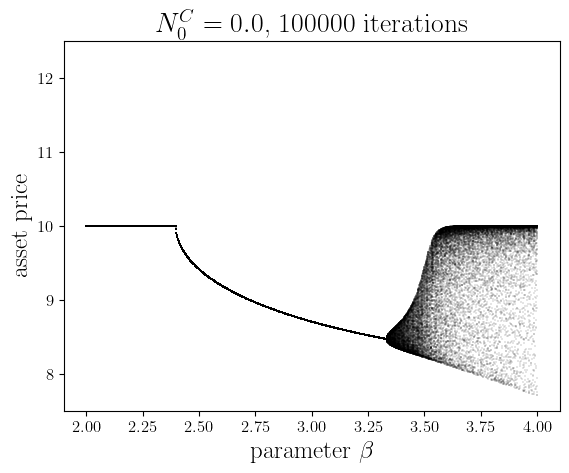

In [140]:
betas = np.linspace(2.0, 4.0, 1000)
xs = np.linspace(-2.5, -0.001, 100)
iterations = 100000
betas, xs, ys = bifurcate(0, [0, 0, r, belief, chi, phi, beta, kappa],
                      -2, betas, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, betas, xs + 10)
ax.set_xlabel(r"parameter $\beta$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("no-intervention-bifurcation-2.png",
            bbox_inches="tight", dpi=300)
plt.show()

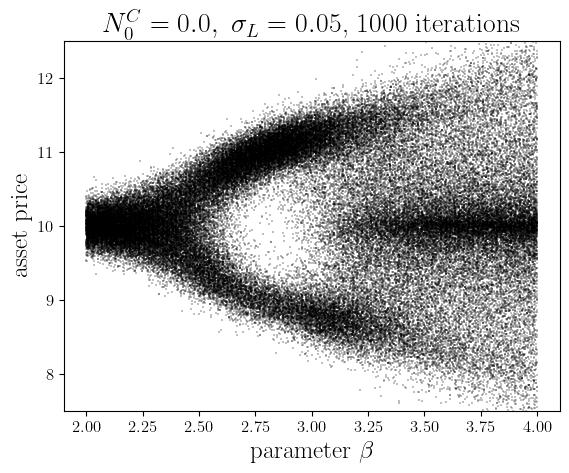

In [150]:
betas = np.linspace(2.0, 4.0, 1000)
xs = np.linspace(0.001, 2.5, 100)
iterations = 1000
betas, xs, ys = bifurcate(liquid_var, [0, 0, r, belief, chi, phi, beta, kappa],
                      -2, betas, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, betas, xs + 10, alpha=0.25)
ax.set_xlabel(r"parameter $\beta$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$, ${iterations}$ iterations")

plt.savefig("no-intervention-bifurcation-stochastic.png",
            bbox_inches="tight", dpi=300)
plt.show()

# Leaning against the wind
## Dynamics

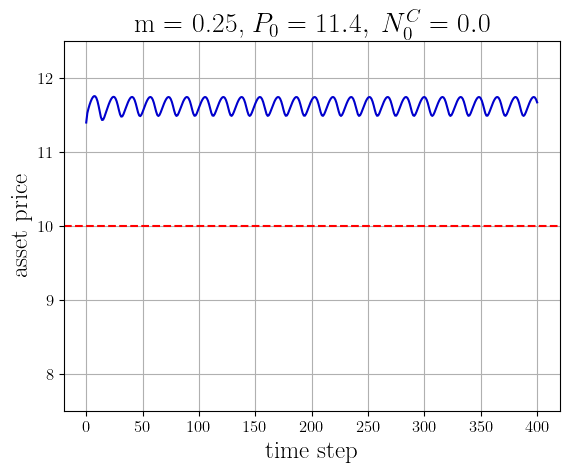

In [163]:
m = 0.25
x0, y0, z0 = 1.4, 1.4, -1.0
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, np.zeros(400), m, 0,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"m = {m},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("lean-against.pdf", bbox_inches="tight")
plt.show()

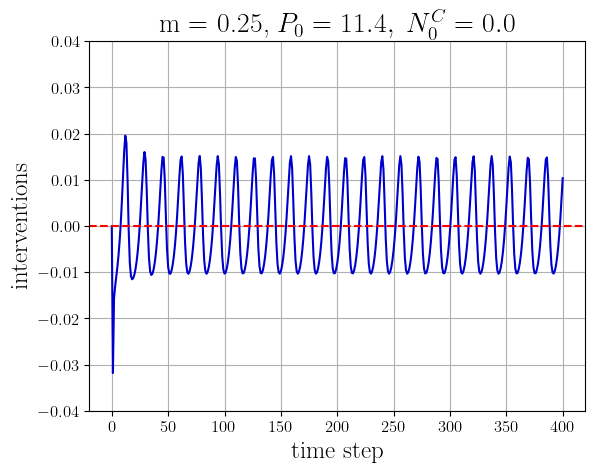

In [166]:
interventions = -m * (xs - ys)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), interventions,
              ylabel="interventions", ylim=(-0.04, 0.04))

ax.axhline(0, c="red", ls="dashed")
ax.set_title(fr"m = {m},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("lean-against-intervention.pdf", bbox_inches="tight")
plt.show()

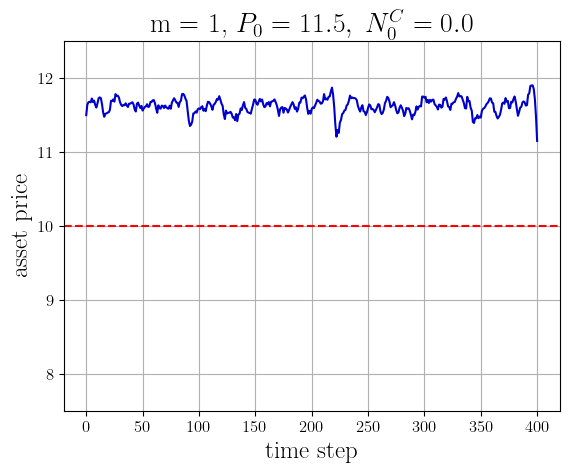

In [167]:
m = 1
x0, y0, z0 = 1.5, 1.5, -1.0
randtrade = np.random.normal(0, liquid_var**0.5, 400)
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, randtrade, m, 0,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"m = {m},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("lean-against-stochastic.pdf", bbox_inches="tight")
plt.show()

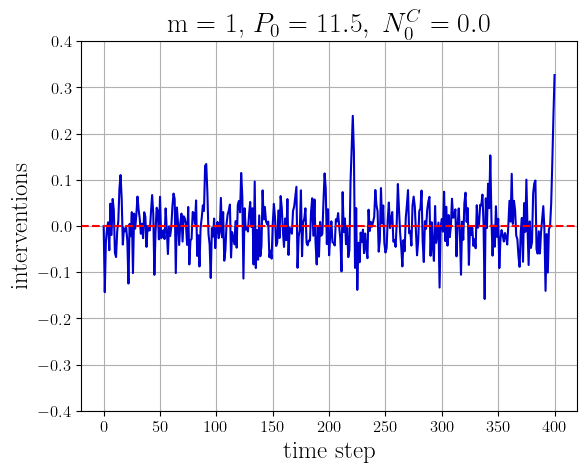

In [168]:
interventions = -m * (xs - ys)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), interventions,
              ylabel="interventions", ylim=(-0.4, 0.4))

ax.axhline(0, c="red", ls="dashed")
ax.set_title(fr"m = {m},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("lean-against-intervention-stochastic.pdf", bbox_inches="tight")
plt.show()

## Bifurcation

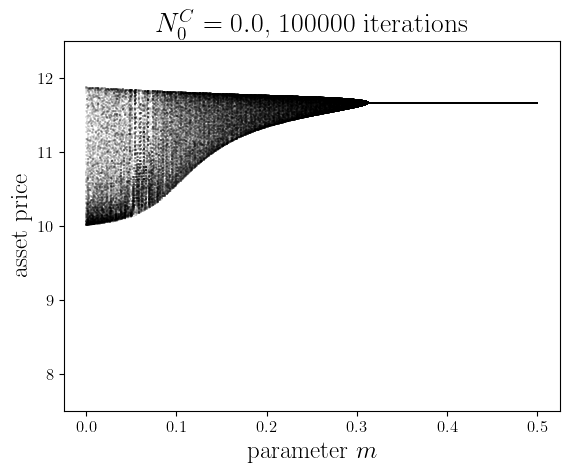

In [193]:
ms = np.linspace(0.0, 0.5, 1000)
xs = np.linspace(0.001, 2.5, 100)
iterations = 100000
ms, xs, ys = bifurcate(0, [0, 0, r, belief, chi, phi, beta, kappa],
                      0, ms, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, ms, xs + 10)
ax.set_xlabel(r"parameter $m$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("lean-against-bifurcation.png",
            bbox_inches="tight", dpi=300)
plt.show()

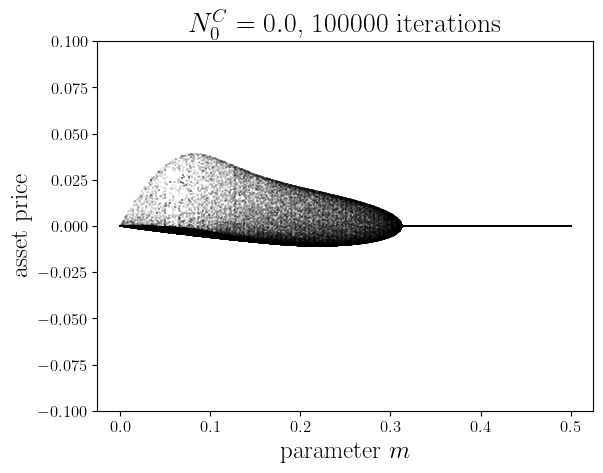

In [194]:
interventions = -ms * (xs - ys)

fig, ax = plt.subplots()
plot_bifurcation(ax, ms, interventions, ylim=(-0.1, 0.1))
ax.set_xlabel(r"parameter $m$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("lean-against-bifurcation-intervention.png",
            bbox_inches="tight", dpi=300)
plt.show()

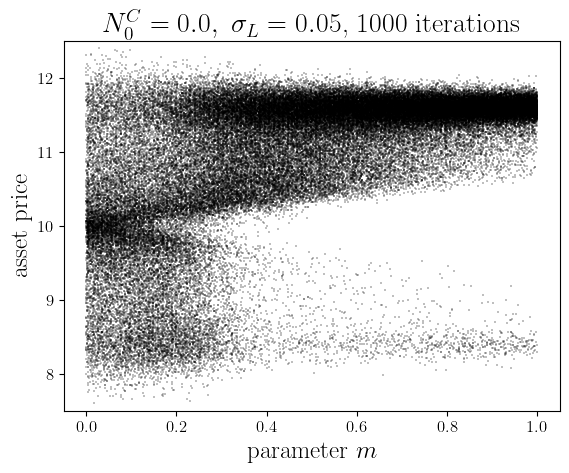

In [195]:
ms = np.linspace(0.0, 1.0, 1000)
xs = np.linspace(0.001, 2.5, 100)
iterations = 1000
ms, xs, ys = bifurcate(liquid_var, [0, 0, r, belief, chi, phi, beta, kappa],
                      0, ms, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, ms, xs + 10, alpha=0.25)
ax.set_xlabel(r"parameter $m$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$, ${iterations}$ iterations")

plt.savefig("lean-against-bifurcation-stochastic.png",
            bbox_inches="tight", dpi=300)
plt.show()

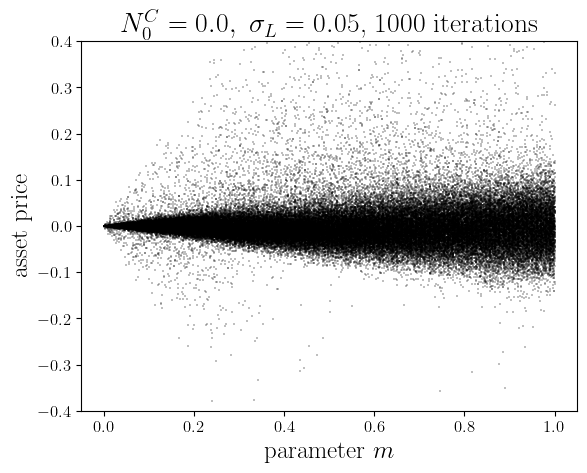

In [196]:
interventions = -ms * (xs - ys)

fig, ax = plt.subplots()
plot_bifurcation(ax, ms, interventions, ylim=(-0.4, 0.4), alpha=0.25)
ax.set_xlabel(r"parameter $m$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$, ${iterations}$ iterations")

plt.savefig("lean-against-bifurcation-stochastic-intervention.png",
            bbox_inches="tight", dpi=300)
plt.show()

## Trends

In [261]:
T = 1000000
ms = np.linspace(0.0, 1.0, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty_like(ms), np.empty_like(ms), np.empty_like(ms),
     np.empty_like(ms), np.empty_like(ms), np.empty_like(ms))
for (i, m) in enumerate(ms):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, m, 0,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, m, 0, r, phi, belief)
    (volatility_avg[i], mispricing_avg[i], abs_intervention_avg[i], profit_avg[i],
     fundamentalist_weight_avg[i], fundamentalist_abs_pos_avg[i]) = (
         np.mean(param) for param in params)
    

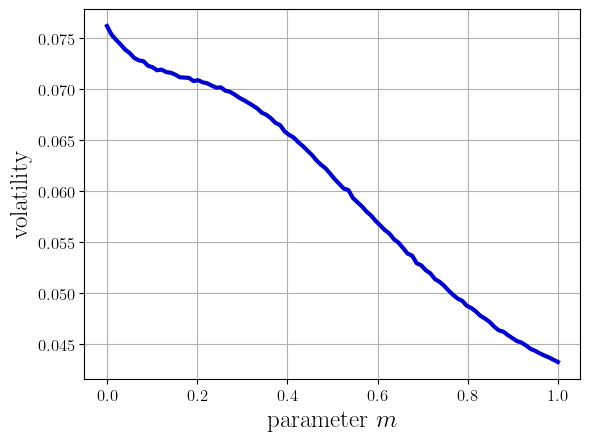

In [262]:
fig, ax = plt.subplots()
ax.plot(ms, volatility_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"volatility")
ax.grid()

plt.savefig("lean-against-volatility.pdf", bbox_inches="tight")
plt.show()

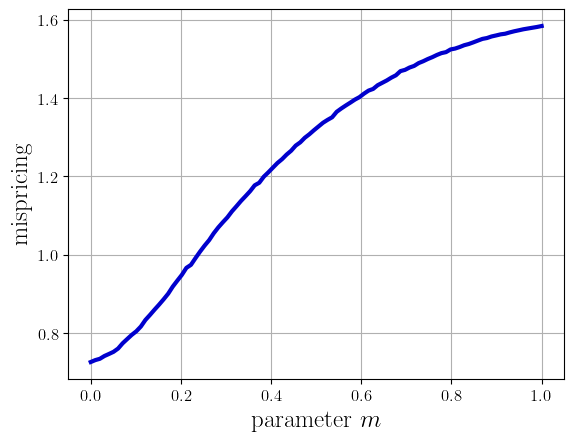

In [263]:
fig, ax = plt.subplots()
ax.plot(ms, mispricing_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"mispricing")
ax.grid()

plt.savefig("lean-against-mispricing.pdf", bbox_inches="tight")
plt.show()

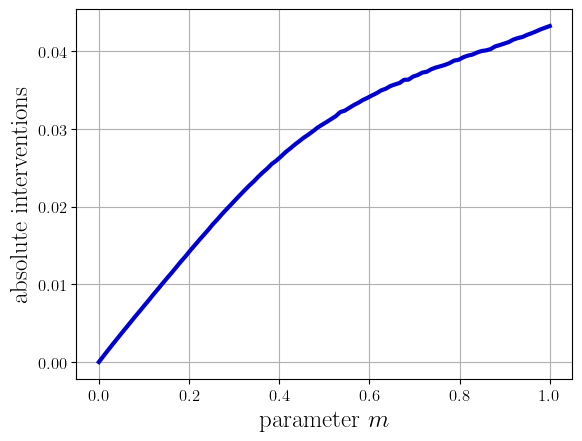

In [264]:
fig, ax = plt.subplots()
ax.plot(ms, abs_intervention_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"absolute interventions")
ax.grid()

plt.savefig("lean-against-absint.pdf", bbox_inches="tight")
plt.show()

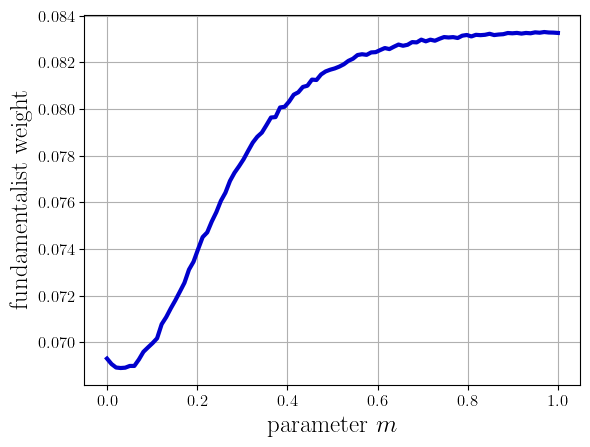

In [265]:
fig, ax = plt.subplots()
ax.plot(ms, fundamentalist_weight_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"fundamentalist weight")
ax.grid()

plt.savefig("lean-against-fundweight.pdf", bbox_inches="tight")
plt.show()

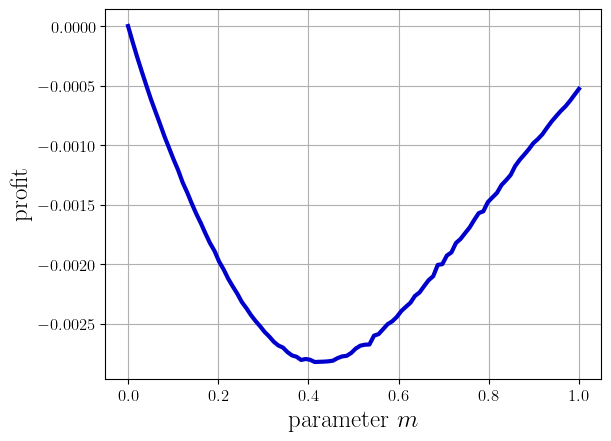

In [266]:
fig, ax = plt.subplots()
ax.plot(ms, profit_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"profit")
ax.grid()

plt.savefig("lean-against-profit.pdf", bbox_inches="tight")
plt.show()

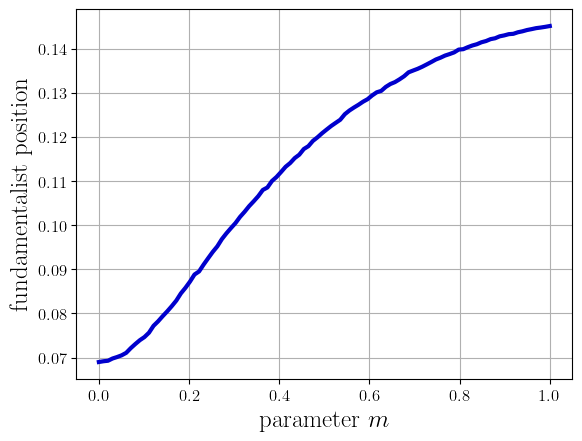

In [267]:
fig, ax = plt.subplots()
ax.plot(ms, fundamentalist_abs_pos_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $m$")
ax.set_ylabel(r"fundamentalist position")
ax.grid()

plt.savefig("lean-against-fundpos.pdf", bbox_inches="tight")
plt.show()

# Targeting long-term fundamentals
## Dynamics

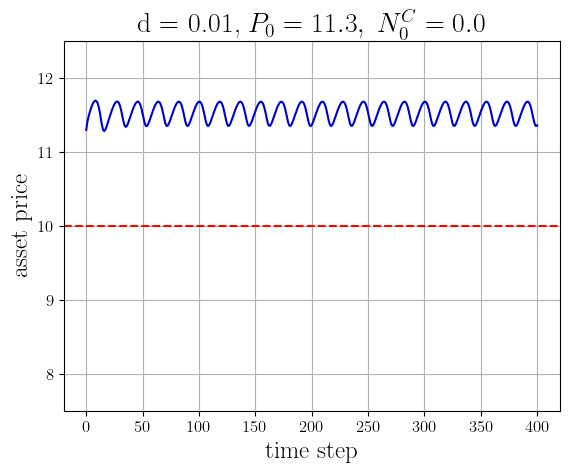

In [14]:
d = 0.01
x0, y0, z0 = 1.3, 1.3, -1.0
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, np.zeros(400), 0, d,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"d = {d},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("target-fundamental.pdf", bbox_inches="tight")
plt.show()

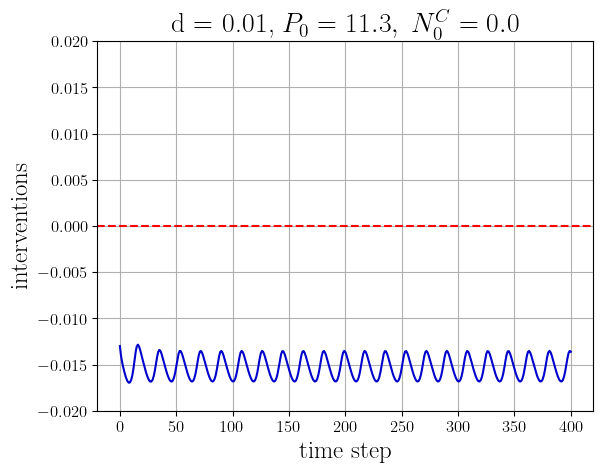

In [15]:
interventions = -d * xs

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), interventions,
              ylabel="interventions", ylim=(-0.02, 0.02))

ax.axhline(0, c="red", ls="dashed")
ax.set_title(fr"d = {d},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("target-fundamental-intervention.pdf", bbox_inches="tight")
plt.show()

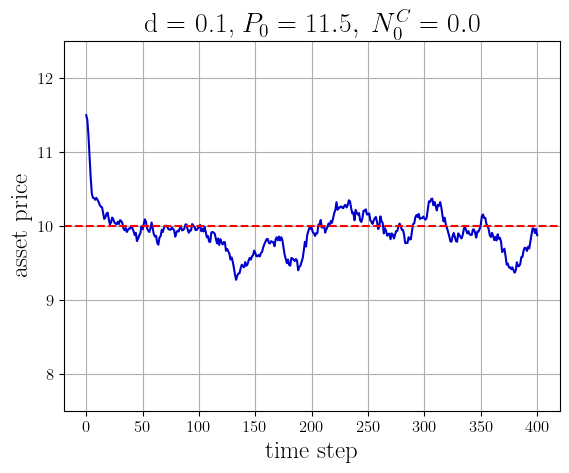

In [16]:
d = 0.1
x0, y0, z0 = 1.5, 1.5, -1.0
randtrade = np.random.normal(0, liquid_var**0.5, 400)
xs, ys, zs = brock_hommes_solution(400, x0, y0, z0, randtrade, 0, d,
                                   r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10)

ax.axhline(10, c="red", ls="dashed")
ax.set_title(fr"d = {d},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("target-fundamental-stochastic.pdf", bbox_inches="tight")
plt.show()

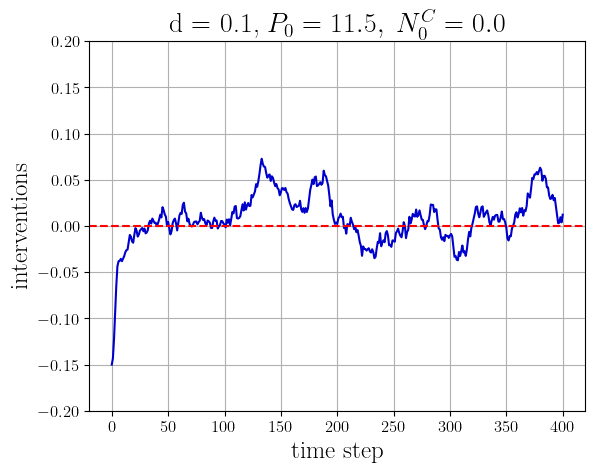

In [17]:
interventions = -d * xs

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), interventions,
              ylabel="interventions", ylim=(-0.2, 0.2))

ax.axhline(0, c="red", ls="dashed")
ax.set_title(fr"d = {d},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("target-fundamental-intervention-stochastic.pdf",
            bbox_inches="tight")
plt.show()

## Bifurcation

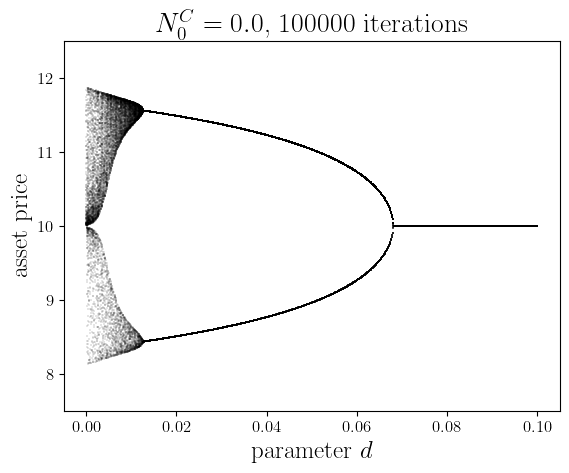

In [272]:
ds = np.linspace(0.0, 0.1, 1000)
xs = np.linspace(0.1, 2.5, 100)
z0 = -1
iterations = 100000
ds, xs, ys = bifurcate(0, [0, 0, r, belief, chi, phi, beta, kappa],
                       1, ds, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, ds, xs + 10)
ax.set_xlabel(r"parameter $d$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("target-fundamental-bifurcation.png",
            bbox_inches="tight", dpi=300)

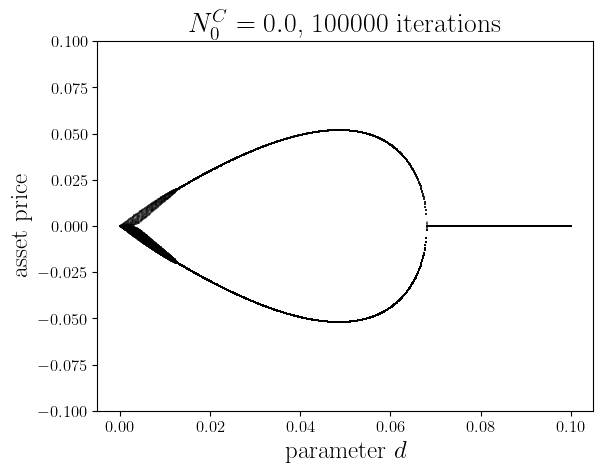

In [273]:
interventions = -ds * xs

fig, ax = plt.subplots()
plot_bifurcation(ax, ds, interventions, ylim=(-0.1, 0.1))
ax.set_xlabel(r"parameter $d$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2}$, ${iterations}$ iterations")

plt.savefig("target-fundamental-bifurcation-intervention.png",
            bbox_inches="tight", dpi=300)
plt.show()

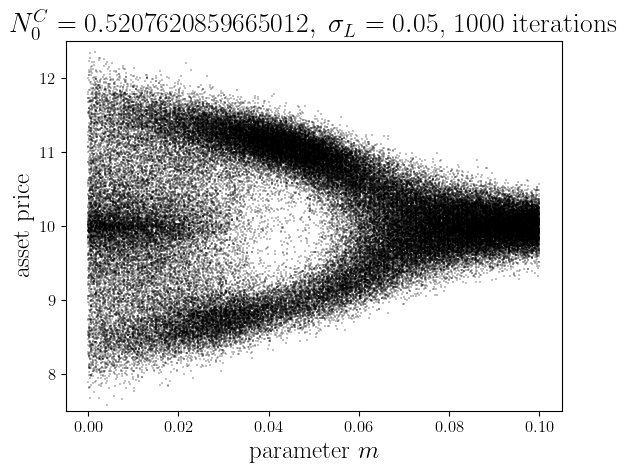

In [270]:
ds = np.linspace(0.0, 0.1, 1000)
xs = np.linspace(0.1, 2.5, 100)
iterations = 1000
ds, xs, ys = bifurcate(liquid_var, [0, 0, r, belief, chi, phi, beta, kappa],
                       1, ds, xs, iterations=iterations)

fig, ax = plt.subplots()
plot_bifurcation(ax, ds, xs + 10, alpha=0.25)
ax.set_xlabel(r"parameter $m$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$, ${iterations}$ iterations")

plt.savefig("target-fundamental-bifurcation-stochastic.png",
            bbox_inches="tight", dpi=300)
plt.show()

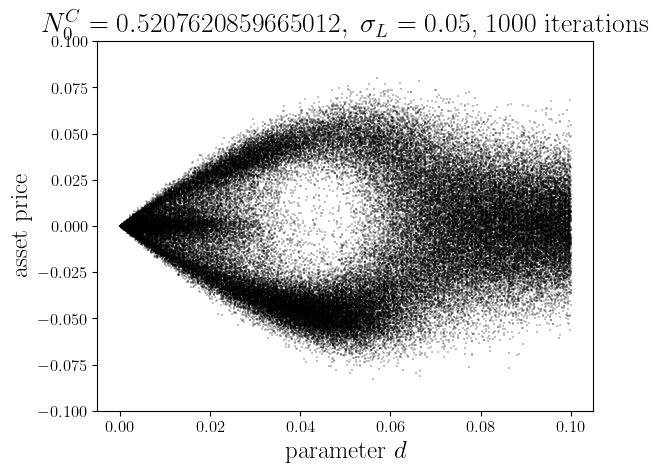

In [271]:
interventions = -ds * xs

fig, ax = plt.subplots()
plot_bifurcation(ax, ds, interventions, ylim=(-0.1, 0.1), alpha=0.25)
ax.set_xlabel(r"parameter $d$")
ax.set_title(fr"$N^C_0 = {(1 + z0) / 2},\ \sigma_L = {liquid_var**0.5}$, ${iterations}$ iterations")

plt.savefig("target-fundamental-bifurcation-stochastic-intervention.png",
            bbox_inches="tight", dpi=300)
plt.show()

## Trends

In [274]:
T = 1000000
ds = np.linspace(0.0, 0.1, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty_like(ds), np.empty_like(ds), np.empty_like(ds),
     np.empty_like(ds), np.empty_like(ds), np.empty_like(ds))
for (i, d) in enumerate(ds):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[i], mispricing_avg[i], abs_intervention_avg[i], profit_avg[i],
     fundamentalist_weight_avg[i], fundamentalist_abs_pos_avg[i]) = (
         np.mean(param) for param in params)
    

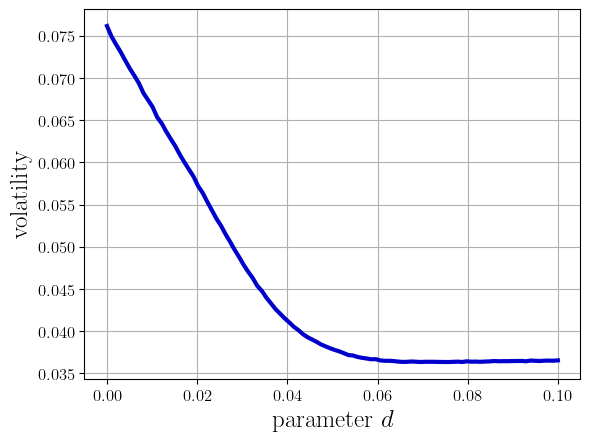

In [275]:
fig, ax = plt.subplots()
ax.plot(ds, volatility_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()

plt.savefig("target-fundamental-volatility.pdf", bbox_inches="tight")
plt.show()

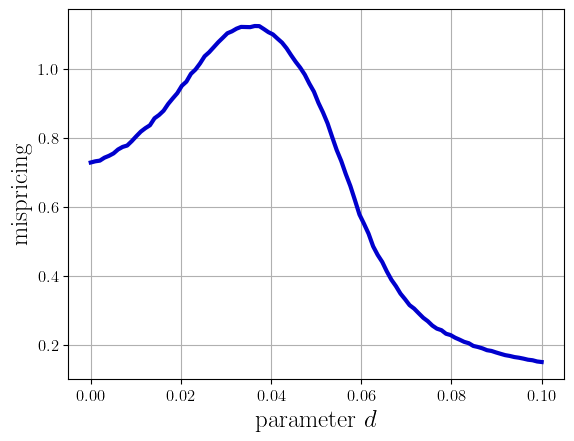

In [276]:
fig, ax = plt.subplots()
ax.plot(ds, mispricing_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"mispricing")
ax.grid()

plt.savefig("target-fundamental-mispricing.pdf", bbox_inches="tight")
plt.show()

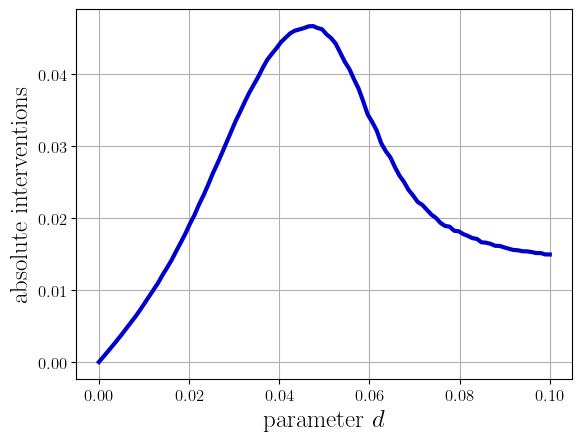

In [277]:
fig, ax = plt.subplots()
ax.plot(ds, abs_intervention_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"absolute interventions")
ax.grid()

plt.savefig("target-fundamental-absint.pdf", bbox_inches="tight")
plt.show()

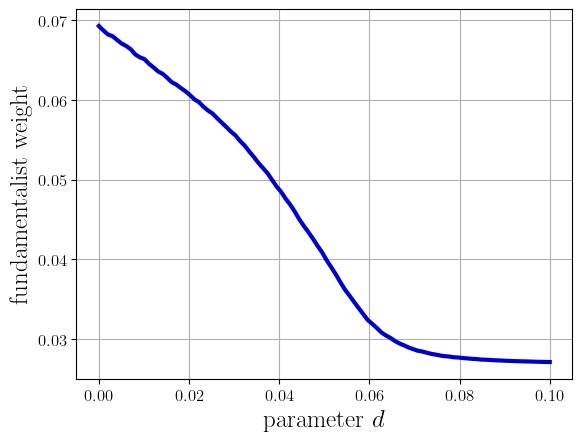

In [278]:
fig, ax = plt.subplots()
ax.plot(ds, fundamentalist_weight_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"fundamentalist weight")
ax.grid()

plt.savefig("target-fundamental-fundweight.pdf", bbox_inches="tight")
plt.show()

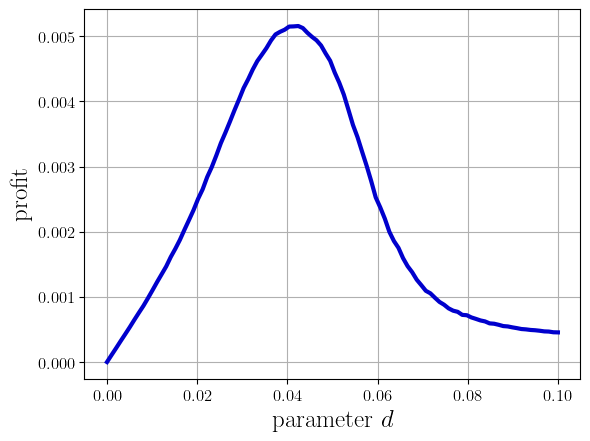

In [279]:
fig, ax = plt.subplots()
ax.plot(ds, profit_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"profit")
ax.grid()

plt.savefig("target-fundamental-profit.pdf", bbox_inches="tight")
plt.show()

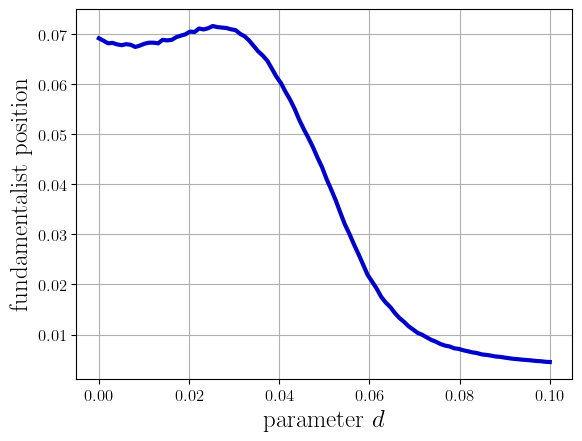

In [280]:
fig, ax = plt.subplots()
ax.plot(ds, fundamentalist_abs_pos_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"fundamentalist position")
ax.grid()

plt.savefig("target-fundamental-fundpos.pdf", bbox_inches="tight")
plt.show()

# Robustness Check
## Trends

In [8]:
T = 1000000
ds = np.linspace(0.0, 0.1, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))),
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))))
for (i, d) in enumerate(ds):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)

    r, belief, chi, phi, beta, kappa = 0.1, 0.8, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[0, i], mispricing_avg[0, i], abs_intervention_avg[0, i], profit_avg[0, i],
     fundamentalist_weight_avg[0, i], fundamentalist_abs_pos_avg[0, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[1, i], mispricing_avg[1, i], abs_intervention_avg[1, i], profit_avg[1, i],
     fundamentalist_weight_avg[1, i], fundamentalist_abs_pos_avg[1, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.2, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[2, i], mispricing_avg[2, i], abs_intervention_avg[2, i], profit_avg[2, i],
     fundamentalist_weight_avg[2, i], fundamentalist_abs_pos_avg[2, i]) = (
         np.mean(param) for param in params)
    

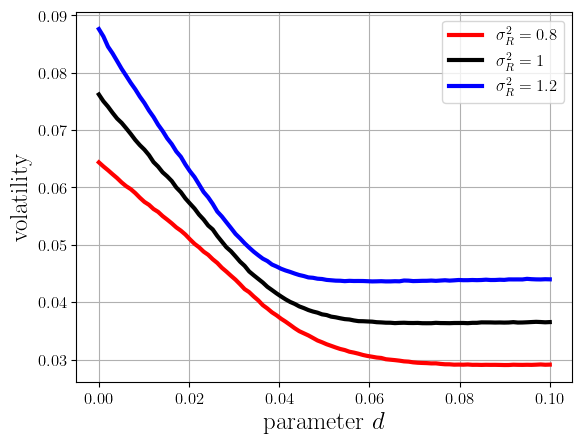

In [9]:
fig, ax = plt.subplots()
ax.plot(ds, volatility_avg[0, :], c="red",
        label=r"$\sigma_R^2=0.8$", lw=3)
ax.plot(ds, volatility_avg[1, :], c="black",
        label=r"$\sigma_R^2=1$", lw=3)
ax.plot(ds, volatility_avg[2, :], c="blue",
        label=r"$\sigma_R^2=1.2$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()
ax.legend()

plt.savefig("robust-belief-volatility.pdf", bbox_inches="tight")
plt.show()

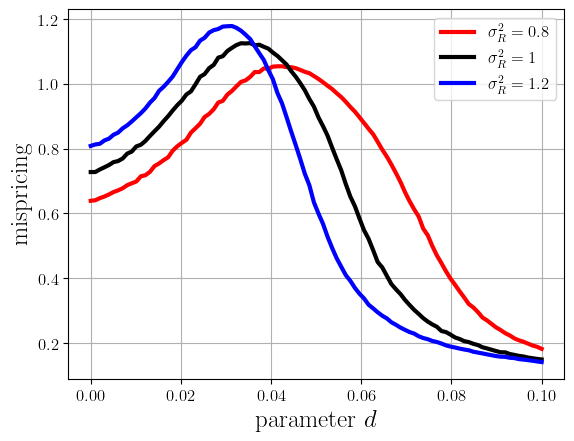

In [10]:
fig, ax = plt.subplots()
ax.plot(ds, mispricing_avg[0, :], c="red",
        label=r"$\sigma_R^2=0.8$", lw=3)
ax.plot(ds, mispricing_avg[1, :], c="black",
        label=r"$\sigma_R^2=1$", lw=3)
ax.plot(ds, mispricing_avg[2, :], c="blue",
        label=r"$\sigma_R^2=1.2$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"mispricing")
ax.grid()
ax.legend()

plt.savefig("robust-belief-mispricing.pdf", bbox_inches="tight")
plt.show()

In [22]:
T = 1000000
ds = np.linspace(0.0, 0.1, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))),
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))))
for (i, d) in enumerate(ds):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)

    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.001
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[0, i], mispricing_avg[0, i], abs_intervention_avg[0, i], profit_avg[0, i],
     fundamentalist_weight_avg[0, i], fundamentalist_abs_pos_avg[0, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[1, i], mispricing_avg[1, i], abs_intervention_avg[1, i], profit_avg[1, i],
     fundamentalist_weight_avg[1, i], fundamentalist_abs_pos_avg[1, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.004
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[2, i], mispricing_avg[2, i], abs_intervention_avg[2, i], profit_avg[2, i],
     fundamentalist_weight_avg[2, i], fundamentalist_abs_pos_avg[2, i]) = (
         np.mean(param) for param in params)

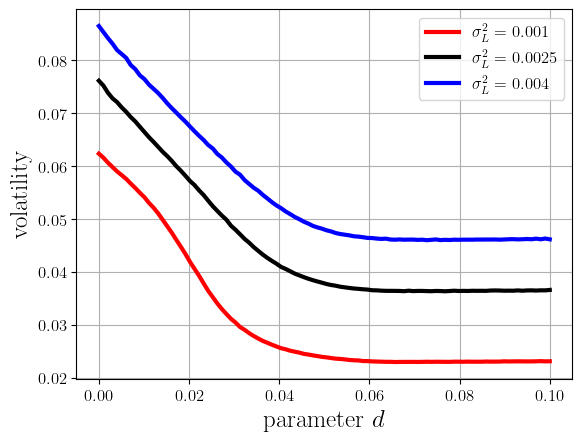

In [23]:
fig, ax = plt.subplots()
ax.plot(ds, volatility_avg[0, :], c="red",
        label=r"$\sigma_L^2=0.001$", lw=3)
ax.plot(ds, volatility_avg[1, :], c="black",
        label=r"$\sigma_L^2=0.0025$", lw=3)
ax.plot(ds, volatility_avg[2, :], c="blue",
        label=r"$\sigma_L^2=0.004$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()
ax.legend()

plt.savefig("robust-randtrade-volatility.pdf", bbox_inches="tight")
plt.show()

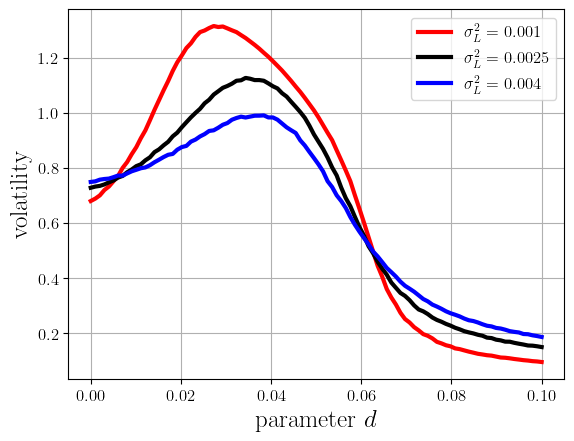

In [24]:
fig, ax = plt.subplots()
ax.plot(ds, mispricing_avg[0, :], c="red",
        label=r"$\sigma_L^2=0.001$", lw=3)
ax.plot(ds, mispricing_avg[1, :], c="black",
        label=r"$\sigma_L^2=0.0025$", lw=3)
ax.plot(ds, mispricing_avg[2, :], c="blue",
        label=r"$\sigma_L^2=0.004$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()
ax.legend()

plt.savefig("robust-randtrade-mispricing.pdf", bbox_inches="tight")
plt.show()

In [18]:
T = 1000000
ds = np.linspace(0.0, 0.1, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))),
     np.empty((3, len(ds))), np.empty((3, len(ds))), np.empty((3, len(ds))))
for (i, d) in enumerate(ds):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)

    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 0.9
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[0, i], mispricing_avg[0, i], abs_intervention_avg[0, i], profit_avg[0, i],
     fundamentalist_weight_avg[0, i], fundamentalist_abs_pos_avg[0, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.0
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[1, i], mispricing_avg[1, i], abs_intervention_avg[1, i], profit_avg[1, i],
     fundamentalist_weight_avg[1, i], fundamentalist_abs_pos_avg[1, i]) = (
         np.mean(param) for param in params)
    
    r, belief, chi, phi, beta, kappa = 0.1, 1.0, 0.2, 1.0, 3.6, 1.2
    liquid_var = 0.0025
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_solution(T, x0, y0, z0, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[2, i], mispricing_avg[2, i], abs_intervention_avg[2, i], profit_avg[2, i],
     fundamentalist_weight_avg[2, i], fundamentalist_abs_pos_avg[2, i]) = (
         np.mean(param) for param in params)

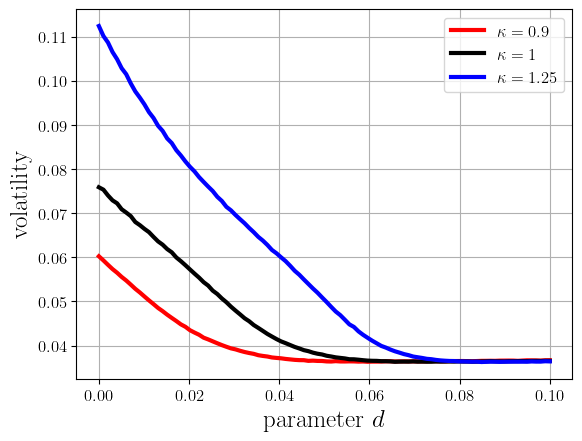

In [20]:
fig, ax = plt.subplots()
ax.plot(ds, volatility_avg[0, :], c="red",
        label=r"$\kappa=0.9$", lw=3)
ax.plot(ds, volatility_avg[1, :], c="black",
        label=r"$\kappa=1$", lw=3)
ax.plot(ds, volatility_avg[2, :], c="blue",
        label=r"$\kappa=1.25$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()
ax.legend()

plt.savefig("robust-fundcost-volatility.pdf", bbox_inches="tight")
plt.show()

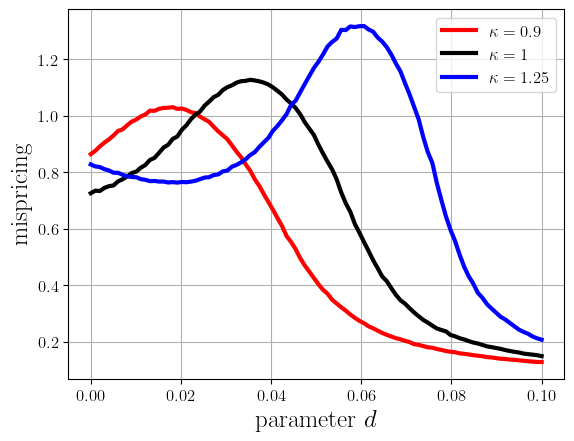

In [21]:
fig, ax = plt.subplots()
ax.plot(ds, mispricing_avg[0, :], c="red",
        label=r"$\kappa=0.9$", lw=3)
ax.plot(ds, mispricing_avg[1, :], c="black",
        label=r"$\kappa=1$", lw=3)
ax.plot(ds, mispricing_avg[2, :], c="blue",
        label=r"$\kappa=1.25$", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"mispricing")
ax.grid()
ax.legend()

plt.savefig("robust-fundcost-mispricing.pdf", bbox_inches="tight")
plt.show()

## Random walking fundamental value

In [25]:
@njit
def brock_hommes_sol_rand(t, x0, y0, z0, randwalk, randtrade, m, d, r,
                          belief, chi, phi, beta, kappa):
    xs, ys, zs = np.empty(t + 1), np.empty(t + 1), np.empty(t + 1)
    xs[0], ys[0], zs[0] = x0, y0, z0
    for i in range(t):
        xs[i + 1], ys[i + 1], zs[i + 1] = brock_hommes_map(
            xs[i] + randwalk[i], ys[i], zs[i], randtrade[i], m, d, r, belief,
            chi, phi, beta, kappa)
    return xs, ys, zs

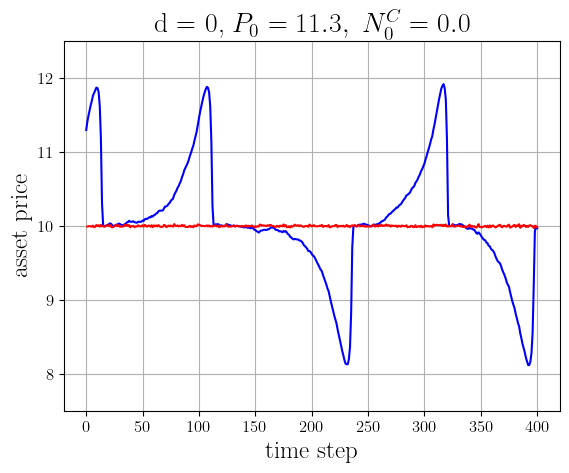

In [26]:
d = 0
walk_sigma = 0.01
randwalk = np.random.normal(0, walk_sigma, 400)
randtrade = np.random.normal(0, liquid_var**0.5, 400)
x0, y0, z0 = 1.3, 1.3, -1.0
xs, ys, zs = brock_hommes_sol_rand(400, x0, y0, z0, randwalk, randtrade,
                                   0, d, r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10,
              color="blue", label="trade price")

ax.plot(np.array(range(1, 401)), randwalk + 10,
        color="red", label="fundamental value")
ax.set_title(fr"$d = {d},\ \sigma_L={liquid_var**0.5},\ \sigma_\delta={walk_sigma}$")

plt.savefig("robust-randwalk-no-intervention.pdf", bbox_inches="tight")
plt.show()

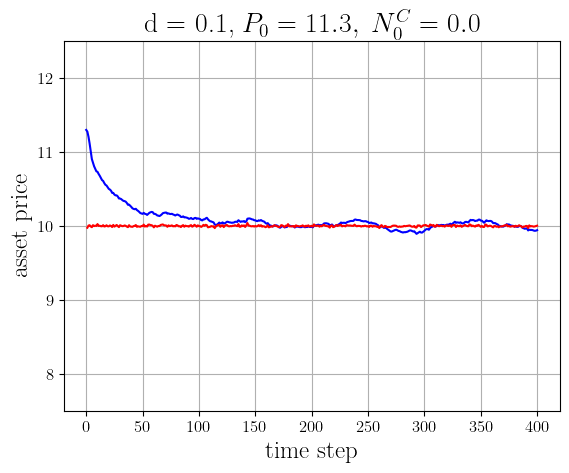

In [27]:
d = 0.1
walk_sigma = 0.01
randwalk = np.random.normal(0, walk_sigma, 400)
x0, y0, z0 = 1.3, 1.3, -1.0
xs, ys, zs = brock_hommes_sol_rand(400, x0, y0, z0, randwalk, np.zeros(400),
                                   0, d, r, belief, chi, phi, beta, kappa)

fig, ax = plt.subplots()
plot_relation(ax, np.array(range(401)), xs + 10,
              color="blue", label="trade price")

ax.plot(np.array(range(1, 401)), randwalk + 10,
        color="red", label="fundamental value")
ax.set_title(fr"d = {d},\ $P_0 = {x0 + 10},\ N^C_0 = {(1 + z0) / 2}$")

plt.savefig("robust-randwalk-target-fundamental.pdf", bbox_inches="tight")
plt.show()

In [28]:
T = 1000000
ds = np.linspace(0.0, 0.1, 100)
(volatility_avg, mispricing_avg, abs_intervention_avg, profit_avg,
 fundamentalist_weight_avg, fundamentalist_abs_pos_avg) = (
     np.empty_like(ds), np.empty_like(ds), np.empty_like(ds),
     np.empty_like(ds), np.empty_like(ds), np.empty_like(ds))
for (i, d) in enumerate(ds):
    x0 = 5 * (np.random.random() - 0.5)
    y0 = x0
    z0 = 2 * (np.random.random() - 0.5)
    walk_sigma = 0.01
    randwalk = np.random.normal(0, walk_sigma, 400)
    randtrade = np.random.normal(0, liquid_var**0.5, T)
    xs, ys, zs = brock_hommes_sol_rand(T, x0, y0, z0, randwalk, randtrade, 0, d,
                                       r, belief, chi, phi, beta, kappa)
    params = brock_hommes_parameters(
        xs, ys, zs, 0, d, r, phi, belief)
    (volatility_avg[i], mispricing_avg[i], abs_intervention_avg[i], profit_avg[i],
     fundamentalist_weight_avg[i], fundamentalist_abs_pos_avg[i]) = (
         np.mean(param) for param in params)

: 

: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(ds, volatility_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"volatility")
ax.grid()

plt.savefig("robust-randwalk-volatility.pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(ds, mispricing_avg, c="mediumblue", lw=3)
ax.set_xlabel(r"parameter $d$")
ax.set_ylabel(r"mispricing")
ax.grid()

plt.savefig("robust-randwalk-mispricing.pdf", bbox_inches="tight")
plt.show()